# Repositional Drug Targets


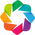

In [1]:
# Native Imports
from collections import defaultdict
from collections import Counter
import os

# Custom Imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr

# Other
from rnaseq_lib.utils import mkdir_p
from rnaseq_lib.de import get_l2fc

from rnaseq_lib.tissues import return_samples
from rnaseq_lib.tissues import get_gene_map
from rnaseq_lib.tissues import get_mab_targets
from rnaseq_lib.tissues import get_civic_genes
from rnaseq_lib.tissues import get_ucsf_genes
from rnaseq_lib.tissues import get_normal_samples
from rnaseq_lib.tissues import get_gtex_samples
from rnaseq_lib.tissues import get_tumor_samples
from rnaseq_lib.tissues.plots import gene_expression_boxplot

from rnaseq_lib.civic import create_civic_drug_disease_dataframe

# Style Settings
sns.set_style('whitegrid')
hv.extension('bokeh')

## Input Data

In [2]:
%%time
# Make output directories
for folder in ['ma-plots', 'box-plots', 'obj']:
    mkdir_p(folder)
    
# Collect samples and target gene lists
samples = return_samples()
mab_genes = set(get_mab_targets())
civic_genes = set(get_civic_genes())
ucsf_genes = set(get_ucsf_genes())

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 124 ms


In [16]:
%%time
# Load expression dataframe. Synapse ID: syn10002767
df_path = '/mnt/rna-seq-analysis/data/xena/deseq2_normalized_tcga_gtex_counts.tsv'
df = pd.read_csv(df_path, sep='\t', index_col=0)

# Map gene ID to gene name
gene_map = get_gene_map()
genes = [gene_map[x.split('.')[0]] for x in df.index]
df.index = genes

CPU times: user 5min 26s, sys: 6.22 s, total: 5min 32s
Wall time: 5min 32s


## Create Tissue Dataframes and MA Plot Objects

In [3]:
%%time
gene_info, plots = {}, {}
for tissue in sorted(samples):
    print 'Processing: {}'.format(tissue)

    # Try to load pandas object, if that fails create dataframe
    plot_df_path = 'obj/{}-MA.panda'.format(tissue)
    try:
        plot_df = pd.read_pickle(plot_df_path)
    except IOError: 
        # Select GTEx and TCGA tumor samples
        gtex_samples = [x for x in samples[tissue] if not x.startswith('TCGA')]
        tumor_samples = [x for x in samples[tissue] if x.endswith('-01')]

        # Calculate log2 Fold Change
        g_med = df[gtex_samples].median(axis=1)
        t_med = df[tumor_samples].median(axis=1)
        l2fc = get_l2fc(g_med, t_med)
        mean = np.log2(df.mean(axis=1) + 1)    
        
        # Create membership masks for genes across gene_sets
        mab_mask = ['MAB' if x in mab_genes else False for x in df.index]
        ucsf_mask = ['UCSF' if x in ucsf_genes else False for x in df.index]
        civic_mask = ['CIViC' if x in civic_genes else False for x in df.index]
        
        # Create dataframe for plots
        plot_df = pd.DataFrame.from_dict(
            {'mean': mean,
             'l2fc': l2fc,
             'gene': df.index,
             'mab': mab_mask,
             'ucsf': ucsf_mask,
             'civic': civic_mask})
        plot_df.to_pickle(plot_df_path)

    # Store Scatter object of plot
    plots[tissue] = hv.Scatter(plot_df, kdims=['mean'], 
                               vdims=['l2fc', 'gene', 'mab', 'ucsf', 'civic'], 
                               group='MA Plot for {}'.format(tissue))
    
    # Try to load pandas object, if that fails create dataframe
    tissue_df_path = 'obj/{}.panda'.format(tissue)
    try:
        tissue_df = pd.read_pickle(tissue_df_path)
    except IOError:
        # Collect information for table and combine with plot_df information
        tissue_df = pd.concat([plot_df, pd.DataFrame.from_dict(
            {'tissue': [tissue for _ in mean],
             'tumor_samples': [len(tumor_samples) for _ in mean],
             'gtex_samples': [len(gtex_samples) for _ in mean],
             'gtex_median': g_med.apply(lambda x: np.log2(x + 1)),
             'tumor_median': t_med.apply(lambda x: np.log2(x + 1)),
             'gtex_std': df[gtex_samples].std(axis=1).apply(lambda x: np.log2(x + 1)),
             'tumor_std': df[tumor_samples].std(axis=1).apply(lambda x: np.log2(x + 1))})], axis=1)
        tissue_df.to_pickle(tissue_df_path)
    gene_info[tissue] = tissue_df

# Construct large table of all tissues
lt = pd.concat([gene_info[x] for x in sorted(gene_info)], axis=0)
lt.to_pickle('obj/all-tissues.panda')

Processing: Adrenal
Processing: Bladder
Processing: Brain
Processing: Breast
Processing: Cervix
Processing: Colon-Small_intestine
Processing: Esophagus
Processing: Kidney
Processing: Liver
Processing: Lung
Processing: Ovary
Processing: Pancreas
Processing: Prostate
Processing: Skin-Head
Processing: Stomach
Processing: Testis
Processing: Thyroid
Processing: Uterus
CPU times: user 2.58 s, sys: 244 ms, total: 2.83 s
Wall time: 3.15 s


In [7]:
lt.head()

,civic,gene,l2fc,mab,mean,ucsf,gtex_median,gtex_samples,gtex_std,tissue,tumor_median,tumor_samples,tumor_std
GRIN3B,False,GRIN3B,-0.279564,False,4.861204,False,2.183691,125,2.211694,Adrenal,1.904127,254,5.975879
RBKS,False,RBKS,-1.032533,False,8.169771,False,9.754996,125,9.187549,Adrenal,8.722463,254,9.612552
SSRP1,False,SSRP1,0.561564,False,12.554440,False,11.374051,125,8.828904,Adrenal,11.935615,254,11.000147
TIGAR,False,TIGAR,0.149907,False,8.633347,False,8.261205,125,6.586014,Adrenal,8.411112,254,7.687602
RNF44,False,RNF44,0.400977,False,11.453589,False,10.534968,125,8.817158,Adrenal,10.935945,254,10.246025


#### Example: Kidney

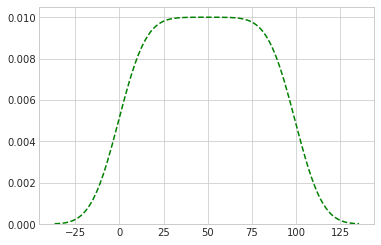

In [9]:
sns.distplot([x for x in range(100)], hist=False, color="g", kde=True, kde_kws={"shade": False, 'linestyle': '--'})

In [8]:
%%opts Scatter [width=900 height=450 tools=['hover']] 
%%opts Scatter [color_index='mab'] (cmap='jet', size=5, alpha=0.25)
%%opts Scatter [legend_position='left' show_legend=True]
plots['Kidney']

:Scatter   [mean]   (l2fc,gene,mab,ucsf,civic)

Find criteria for Kidney (should be CA9 and CD70)

In [105]:
lt[(lt.tissue == 'Kidney') & (lt.l2fc > 3) & (lt.tumor_median > 5) & (lt.gtex_median < 3) & (lt.mab=='MAB')]

,civic,gene,l2fc,mab,mean,ucsf,gtex_median,gtex_samples,gtex_std,tissue,tumor_median,tumor_samples,tumor_std
CA9,False,CA9,10.108606,MAB,10.054547,False,2.382305,27,6.340710,Kidney,12.490911,882,5755.241239
CD70,False,CD70,5.935974,MAB,7.258168,False,2.986352,27,38.064012,Kidney,8.922326,882,484.162950


### Collect Candidate MAB Targets

In [41]:
candidate_mab_targets = {}
for tissue in sorted(samples):
    candidate_mab_targets[tissue] = list(lt[(lt.tissue == tissue) & 
                                            (lt.l2fc > 3) & 
                                            (lt.tumor_median > 5) & 
                                            (lt.gtex_median < 3) & 
                                            (lt.mab=='MAB')].index)

In [42]:
Counter(candidate_mab_targets).most_common()

[('Skin-Head', [u'TNFRSF9']),
 ('Bladder', [u'TNFRSF9']),
 ('Breast', [u'TNFRSF9']),
 ('Esophagus', [u'MUC16', u'TNFRSF9']),
 ('Colon-Small_intestine', [u'IL1A', u'TNFRSF9']),
 ('Stomach', [u'GUCY2C']),
 ('Uterus', [u'FUT3', u'FOLR1', u'TNFRSF9']),
 ('Ovary', [u'FUT3', u'FOLR1', u'TNFRSF9']),
 ('Cervix', [u'CD70', u'IL1A', u'TNFRSF9']),
 ('Pancreas', [u'CCR4', u'CD70', u'IL1A', u'TNFRSF9', u'CTLA4']),
 ('Kidney', [u'CA9', u'CD70']),
 ('Lung', [u'CA9']),
 ('Thyroid', []),
 ('Testis', []),
 ('Liver', []),
 ('Brain', []),
 ('Adrenal', []),
 ('Prostate', [])]

In [71]:
tnf = {tissue: gene_expression_boxplot(df.T, tissue, 'TNFRSF9') 
       for tissue in sorted(candidate_mab_targets) if 'TNFRSF9' in candidate_mab_targets[tissue]}

In [72]:
(tnf['Bladder'] + tnf['Breast'] + tnf['Cervix'] + \
 tnf['Colon-Small_intestine'] + tnf['Esophagus'] + \
 tnf['Ovary'] + tnf['Pancreas'] + tnf['Skin-Head'] + \
 tnf['Uterus']).cols(3)

:Layout
   .BoxWhisker.I    :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.II   :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.III  :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.IV   :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.V    :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.VI   :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.VII  :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.VIII :BoxWhisker   [dataset]   (counts)
   .BoxWhisker.IX   :BoxWhisker   [dataset]   (counts)

## CIViC Drugs, Genes, and Diseases

In [53]:
civic = create_civic_drug_disease_dataframe()

100% |########################################################################|


In [73]:
lt[(lt.l2fc > 3) & (lt.tumor_median > 5) & (lt.gtex_median < 3) & (lt.civic=='CIViC')]

,civic,gene,l2fc,mab,mean,ucsf,gtex_median,gtex_samples,gtex_std,tissue,tumor_median,tumor_samples,tumor_std
TERT,CIViC,TERT,5.066162,False,5.010615,UCSF,0.000000,9,1.044276,Bladder,5.066162,407,7.661209
RRM2,CIViC,RRM2,5.509331,False,10.348693,False,2.558907,1142,5.148621,Brain,8.068238,662,9.873128
PBK,CIViC,PBK,5.503477,False,8.336289,False,2.015503,1142,3.457674,Brain,7.518979,662,9.009396
CBLC,CIViC,CBLC,7.733244,False,9.126463,False,2.708858,650,9.663645,Esophagus,10.442101,181,9.968879
CDX2,CIViC,CDX2,7.261263,False,8.100042,UCSF,0.000000,650,4.639559,Esophagus,7.261263,181,10.163193
HOXB13,CIViC,HOXB13,6.787562,False,9.422911,False,0.000000,650,3.686582,Esophagus,6.787562,181,8.636388
UGT1A1,CIViC,UGT1A1,4.624418,False,8.739202,False,1.924784,650,7.470522,Esophagus,6.549202,181,8.339807
CDKN2A,CIViC,CDKN2A,4.421849,False,9.570484,False,2.771379,27,6.961958,Kidney,7.193228,882,8.578942
PBK,CIViC,PBK,5.110797,False,8.336289,False,2.196286,110,6.856475,Liver,7.307083,369,8.212441
UGT1A1,CIViC,UGT1A1,5.018114,False,8.739202,False,0.000000,287,5.099628,Lung,5.018114,1011,8.419692


In [55]:
civic.head()

,Cancer,Drugs,Gene,Aliases,Variant-Name,Description
0,Non-small Cell Lung Carcinoma,Crizotinib,ALK,"ALK,NBLST3,CD246",EML4-ALK L1152R,"ALK amplifications, fusions and mutations have..."
1,Non-small Cell Lung Carcinoma,Crizotinib,ALK,"ALK,NBLST3,CD246",ALK FUSIONS,"ALK amplifications, fusions and mutations have..."
2,Non-small Cell Lung Carcinoma,IPI-504,ALK,"ALK,NBLST3,CD246",ALK FUSIONS,"ALK amplifications, fusions and mutations have..."
3,Non-small Cell Lung Carcinoma,Alectinib (CH5424802),ALK,"ALK,NBLST3,CD246",ALK FUSIONS,"ALK amplifications, fusions and mutations have..."
4,Non-small Cell Lung Carcinoma,Brigatinib,ALK,"ALK,NBLST3,CD246",ALK FUSIONS,"ALK amplifications, fusions and mutations have..."


In [77]:
civic[civic.Gene == 'RRM2']

,Cancer,Drugs,Gene,Aliases,Variant-Name,Description
3069,Pancreatic Cancer,Gemcitabine,RRM2,"RRM2,RR2M,RR2,R2",OVEREXPRESSION,


In [81]:
lt[(lt.gene == 'RRM2') & (lt.tissue=='Pancreas')]

,civic,gene,l2fc,mab,mean,ucsf,gtex_median,gtex_samples,gtex_std,tissue,tumor_median,tumor_samples,tumor_std
RRM2,CIViC,RRM2,4.542428,False,10.348693,False,5.560489,165,7.744157,Pancreas,10.102917,178,9.688625
